In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import netgraph
import copy
import time

Make Graph

In [2]:
# SET GRAPH PARAMETERS
#numNodes = 15
#degree = 1   

def genGraph(numNodes, graphType):
    # MAKE GRAPHS
    if(graphType == 'gn_graph'):
        generatedGraph = nx.gn_graph(numNodes, None, None, 0)
    if(graphType == 'complete_graph'):
        generatedGraph = nx.complete_graph(5)
    if(graphType == 'random_regular_graph'):
        generatedGraph = nx.random_regular_graph(2, numNodes, seed=None)

    

    # INITIALIZE PARAMETERS
    # COLOR (also used as visited. blue == not visited, red == visiting, not all edges yet considered, green == visted, all edges visited.)
    color_map3 = ["tab:blue"]*len(generatedGraph.nodes)
    nx.set_node_attributes(generatedGraph, dict(zip(generatedGraph.nodes(), color_map3)), "color") # for each node, set attribute color to the value in the color map
    # DISTANCE (inaccurate and unused. theoretically node distance from initial vertex)
    distance_map3 = [None]*len(generatedGraph.nodes)
    nx.set_node_attributes(generatedGraph, dict(zip(generatedGraph.nodes(), distance_map3)), "dist") 
    # PREVIOUS (the node we came from before to access current node)
    previous_map3 = [None]*len(generatedGraph.nodes)
    nx.set_node_attributes(generatedGraph, dict(zip(generatedGraph.nodes(), previous_map3)), "prev") 
    # LAST TOUCH (the timestep node is left for the last time)
    last_touch_map3 = [None]*len(generatedGraph.nodes)
    nx.set_node_attributes(generatedGraph, dict(zip(generatedGraph.nodes(), last_touch_map3)), "last_touch") 

    return generatedGraph
    

Print Generated Graph

In [3]:
# PRINT GRAPH
#nx.draw(dfsGraph, node_color=nx.get_node_attributes(dfsGraph, 'color').values(), with_labels=True)

Implementation of DFS Topological Sort

In [4]:
# page 53 ln6
# an algorithm for topological sort
# call DFS(G) to compute finishing times f[v] for each vertex v
# as each vertex is finished, insert it onto the front of a linked list
# return the linked list of vertices

# FUNCTION FOR DFS VISITING
def dfsVisit(node, graph, timestep, topoList):
    timestep = timestep + 1
    nx.set_node_attributes(graph, {node:"tab:red"}, "color")
    nx.set_node_attributes(graph, {node:timestep}, "dist")
    for subnode in graph.successors(node):
        if(nx.get_node_attributes(graph, 'color')[subnode]=='tab:blue'): # means we didn't visit the child before
            nx.set_node_attributes(graph, {subnode:node}, "prev")
            topoList, nodeUnused, timestep = dfsVisit(subnode, graph, timestep, topoList)
    nx.set_node_attributes(graph, {node:"tab:green"}, "color") # at this point we have considered all edges
    timestep = timestep + 1
    nx.set_node_attributes(graph, {node:timestep}, "last_touch") # at this point we have considered all edges
    topoList.append(node)
    return topoList, node, timestep


# RUN DFS TOPOLOGICAL SORT
def dfsTopo(dfsGraph, displayGraph):
    timestep = 0
    # randomize the list of nodes in the graph before looping through them. This reduces the likelyhood of simply traversing the graph from the bottom up, making toposort less interesting
    randomizedDFSGraphNodes = list(dfsGraph.nodes)
    random.shuffle(randomizedDFSGraphNodes) # our randomized list of all nodes in the graph
    topoList = [] # will store our topological order of visited nodes
    # BEGIN TIMING
    dfst0 = time.time()
    for node in randomizedDFSGraphNodes: # page 53 lecture note 6
        if not (nx.get_node_attributes(dfsGraph, 'color')[node]=='tab:green'): # means we didn't visit it before
            topoList, nodeUnused, timestep = dfsVisit(node, dfsGraph, timestep, topoList) # run DFS starting from this node, record topological ordering
    # END TIMING
    dfst1 = time.time()
    dfs_runtime = dfst1-dfst0
    
    # PRINT TOPOLOGICALLY SORTED GRAPH
    if(displayGraph==True):
        # the two dictionaries must each have identical keys before new dictionary creation below
        assert(nx.get_node_attributes(dfsGraph, 'last_touch').keys() <= nx.get_node_attributes(dfsGraph, 'prev').keys()) 
        # make node labels including topological sort
        nodeLabelsDictionary = {} # node, previous, last touch
        for key in nx.get_node_attributes(dfsGraph, 'last_touch'):
            prev = nx.get_node_attributes(dfsGraph, 'prev')[key]
            last = nx.get_node_attributes(dfsGraph, 'last_touch')[key]
            nodeLabelsDictionary[key] = "N:" + str(key) + "\nP:" + str(prev) + "\nF:" + str(last)
        #print("Node labels dictionary = " + str(nodeLabelsDictionary))
        # draw simple graph
        nx.draw(dfsGraph, node_color=nx.get_node_attributes(dfsGraph, 'color').values(), with_labels=True)
        # draw graph with more complex labels
        #nx.draw(dfsGraph, node_color=nx.get_node_attributes(dfsGraph, 'color').values(), labels = nodeLabelsDictionary, with_labels=True)
    return dfs_runtime, topoList

Implementation of BFS Topological Sort

In [5]:
def isEmpty(stack):
    if not stack:
        return True
    else:
        return False
        
# FUNCTION FOR BFS VISITING
def bfsVisit(node, graph):
    queue = []
    topoList = []
    timestep = 0
    
    # if we've visited the node before, we return an empty topoList
    if(not nx.get_node_attributes(graph, 'color')[node]=='tab:blue'): # only add node if we haven't visited it before
        return topoList # empty
       
    while(not node == None):
        # add all unvisted children of node to queue 
        for subnode in graph.successors(node):
            if(nx.get_node_attributes(graph, 'color')[subnode]=='tab:blue'): # means we didn't visit the child before
                queue.append(subnode) # add child to queue
                nx.set_node_attributes(graph, {subnode:"tab:green"}, "color") # mark child as visited (it *will* be visited - we need to record this now to avoid duplicate adds to the queue)
        
        # mark current node as visited 
        nx.set_node_attributes(graph, {node:"tab:green"}, "color") 
        topoList.append(node) # append current node to traversed list

        # The following attributes are used in DFS and haven't been checked for accuracy here
        nx.set_node_attributes(graph, {node:timestep}, "dist")
        nx.set_node_attributes(graph, {node:timestep}, "last_touch") # at this point we have considered all edges
        timestep = timestep + 1

        # move onto the next node
        if(isEmpty(queue)):
            node = None
        else:
            node = queue.pop(0)   
    
    return topoList

# RUN BFS TOPOLOGICAL SORT
def bfsTopo(bfsGraph):
    # randomize the list of nodes in the graph before looping through them. This reduces the likelyhood of simply traversing the graph from the bottom up, making toposort less interesting
    randomizedBFSGraphNodes = list(bfsGraph.nodes)
    random.shuffle(randomizedBFSGraphNodes) # our randomized list of all nodes in the graph
    print(list(randomizedBFSGraphNodes))
    topoList = [] # will store our topological order of visited nodes
    # BEGIN TIMING
    bfst0 = time.time()
    for node in randomizedBFSGraphNodes: # page 53 lecture note 6
        if not (nx.get_node_attributes(bfsGraph, 'color')[node]=='tab:green'): # means we didn't visit it before
            topoList = topoList + bfsVisit(node, bfsGraph) # run BFS starting from this node, record topological ordering
    # END TIMING
    bfst1 = time.time()
    bfs_runtime = bfst1-bfst0
    return bfs_runtime, topoList

Testing BFS Topological sort

[8, 5, 13, 12, 10, 11, 14, 6, 4, 0, 7, 9, 2, 1, 3]
bfsRuntime 0.0009336471557617188 bfsTopo [8, 4, 1, 0, 5, 13, 3, 2, 7, 12, 9, 10, 11, 14, 6]


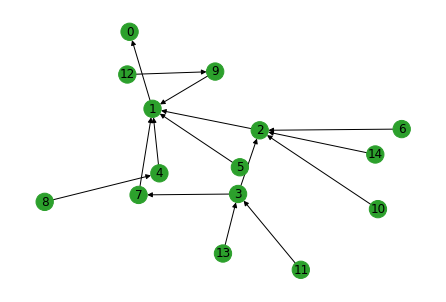

In [11]:
graphTest = genGraph(15, 'gn_graph')
graphTest.add_edge(3,7)
#bfstopo = bfsVisit(11,graphTest)
bfsRuntime, bfstopo = bfsTopo(graphTest)
print("bfsRuntime " + str(bfsRuntime) + " bfsTopo " + str(bfstopo))
nx.draw(graphTest, node_color=nx.get_node_attributes(graphTest, 'color').values(), with_labels=True)

Generate Graphs, run DFS and BFS topo sort

In [7]:
# GENERATE GRAPHS
#graph3 = genGraph(15000, 'gn_graph')
nodeSizes = list(range(10, 2500, 20)) #10, 2500, 20
dfs_runtime_list = []
# MAKE COPIES OF THE GRAPH
for k in nodeSizes: # start stop step should be 
    print("Generating and runing graph for node size " + str(k))
    graph3 = genGraph(k, 'gn_graph')
    dfsGraph = copy.deepcopy(graph3) # copy of the graph for dfs topological sort algorithm
    bfsGraph = copy.deepcopy(graph3) # copy of the graph for bfs topological sort algorithm 
    # RUN DFS TOPO SORT
    dfs_runtime, DFS_topo_list = dfsTopo(dfsGraph, False)
    dfs_runtime_list.append(dfs_runtime)

# PRINT DFS TOPO LIST
#print("DFS topo list = " + str(DFS_topo_list))
print("Runtime = " + str(dfs_runtime_list))

Generating and runing graph for node size 10
Generating and runing graph for node size 30
Generating and runing graph for node size 50
Generating and runing graph for node size 70
Generating and runing graph for node size 90
Generating and runing graph for node size 110
Generating and runing graph for node size 130
Generating and runing graph for node size 150
Generating and runing graph for node size 170
Generating and runing graph for node size 190
Generating and runing graph for node size 210
Generating and runing graph for node size 230
Generating and runing graph for node size 250
Generating and runing graph for node size 270
Generating and runing graph for node size 290
Generating and runing graph for node size 310
Generating and runing graph for node size 330
Generating and runing graph for node size 350
Generating and runing graph for node size 370
Generating and runing graph for node size 390
Generating and runing graph for node size 410
Generating and runing graph for node si

KeyboardInterrupt: 

Make Time Graphs After Algorithms

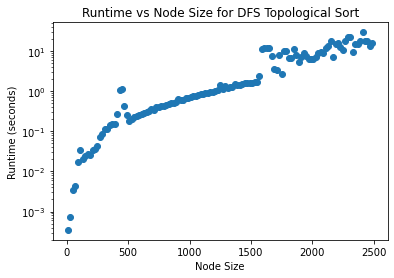

In [ ]:
# PRINT GRAPH
#nx.draw(graph3, node_color=nx.get_node_attributes(graph3, 'color').values(), with_labels=True)
plt.plot(nodeSizes, dfs_runtime_list, 'o')
plt.xlabel("Node Size")
plt.ylabel("Runtime (seconds)")
plt.yscale("log")
plt.title("Runtime vs Node Size for DFS Topological Sort")
plt.show()